In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.transforms import Resize
from PIL import Image
from skimage.color import rgb2lab
import os
import torch.utils.data as data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import PIL, urllib
from torchvision import utils
from torch.utils.data import Subset
torch.manual_seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 2, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train(model, train_loader, val_loader, num_epochs=5, learning_rate=1e-4):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs, losses, train_acc, val_acc = [], [], [], []
    n = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if CUDA is available
    model.to(device)  # Move model to the GPU if available

    total_batches = len(train_loader) * num_epochs

    for epoch in range(num_epochs):
        for batch_idx, imgs in enumerate(train_loader):
            imgs_size = imgs.size()
            img_lab = rgb2lab(imgs.permute(0, 2, 3, 1).cpu())  # Convert images to LAB space
            L = torch.tensor(img_lab[:, :, :, 0], dtype=torch.float32).unsqueeze(1).to(device) # Extract L channel and move to GPU
            AB = torch.tensor(img_lab[:, :, :, 1:], dtype=torch.float32).to(device) / 128.0  # Extract AB channels and move to GPU, normalize
            AB_resized = AB.permute(0, 3, 1, 2)

            out = model(L)
            loss = criterion(out, AB_resized)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            progress_percent = ((epoch * len(train_loader)) + batch_idx) / total_batches * 100
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Progress: {progress_percent:.2f}%')

        train_accuracy = get_accuracy(model, train_loader)
        val_accuracy = get_accuracy(model, val_loader)
        losses.append(loss.item())
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
        epochs.append(epoch)

        print("Epoch #{}, Training Accuracy {:.7f}, Validation Accuracy {:.7f}, Loss {:.7f}".format(epoch, train_accuracy, val_accuracy, loss.item()))

    # Plotting
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch #")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def get_accuracy(model, dataloader):
    correct = 0
    total = 0
    device = next(model.parameters()).device
    model.eval()
    for batch_idx, imgs in enumerate(dataloader):
        imgs = imgs.to(device)

        # Convert RGB images to LAB
        img_lab = rgb2lab(imgs.permute(0, 2, 3, 1).cpu().numpy())
        L = torch.tensor(img_lab[:, :, :, 0], dtype=torch.float32).unsqueeze(1).to(device)
        AB = torch.tensor(img_lab[:, :, :, 1:], dtype=torch.float32).to(device) / 128.0
        AB_resized = AB.permute(0, 3, 1, 2)

        out = model(L)
        predicted_AB = out.permute(0, 2, 3, 1).detach().cpu().numpy() * 128.0

        AB_np = AB.squeeze().cpu().numpy() * 128.0
        difference = np.abs(predicted_AB - AB_np)
        correct += np.sum(difference < 5)
        total += np.prod(AB_np.shape)
    accuracy = correct / total
    return accuracy


In [ ]:
google_drive_path = '/content/drive/MyDrive/APS360_Project_Data/New_APS_360_Data/landscape_Images/color'
from torch.utils.data import Subset
import torch
from torchvision.transforms import Resize
import torch.nn.functional as F
from skimage.color import rgb2lab
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_dataAug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.RandomVerticalFlip(p=0.059)]
)


subset = Subset(CustomImageDataset(google_drive_path, transform=transform_dataAug), range(6000))
subset_1 = Subset(CustomImageDataset(google_drive_path, transform=transform), range(6001, 6500))

train_loader = DataLoader(subset, batch_size=128, shuffle=True)
val_loader = DataLoader(subset_1, batch_size=128, shuffle=True)

(-0.5, 255.5, 255.5, -0.5)

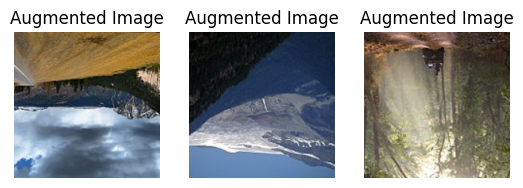

In [ ]:
import matplotlib.pyplot as plt
augmented_img_1 = subset[74].permute(1, 2, 0).numpy()
plt.subplot(1, 3, 1)
plt.imshow(augmented_img_1)
plt.title('Augmented Image')
plt.axis('off')

augmented_img_2 = subset[104].permute(1, 2, 0).numpy()
plt.subplot(1, 3, 2)
plt.imshow(augmented_img_2)
plt.title('Augmented Image')
plt.axis('off')

augmented_img_3 = subset[946].permute(1, 2, 0).numpy()
plt.subplot(1, 3, 3)
plt.imshow(augmented_img_3)
plt.title('Augmented Image')
plt.axis('off')


In [ ]:
# Training
model = ColorizationModel()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Train the model
train(model, train_loader, val_loader, num_epochs=50, learning_rate=0.0001)

# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/APS360_Project_Data/colorization_model_100.pth')

In [8]:
# Test Data
google_drive_path = '/content/drive/MyDrive/APS360_Project_Data/New_Test_data'
from torch.utils.data import Subset
import torch
from torchvision.transforms import Resize
import torch.nn.functional as F
from skimage.color import rgb2lab
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
test_dataset = CustomImageDataset(google_drive_path, transform=transform)

<ipython-input-13-63e8513e46f3>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  AB = torch.tensor(AB, dtype=torch.float32) * 128


TypeError: tight_layout() got an unexpected keyword argument 'hspace'

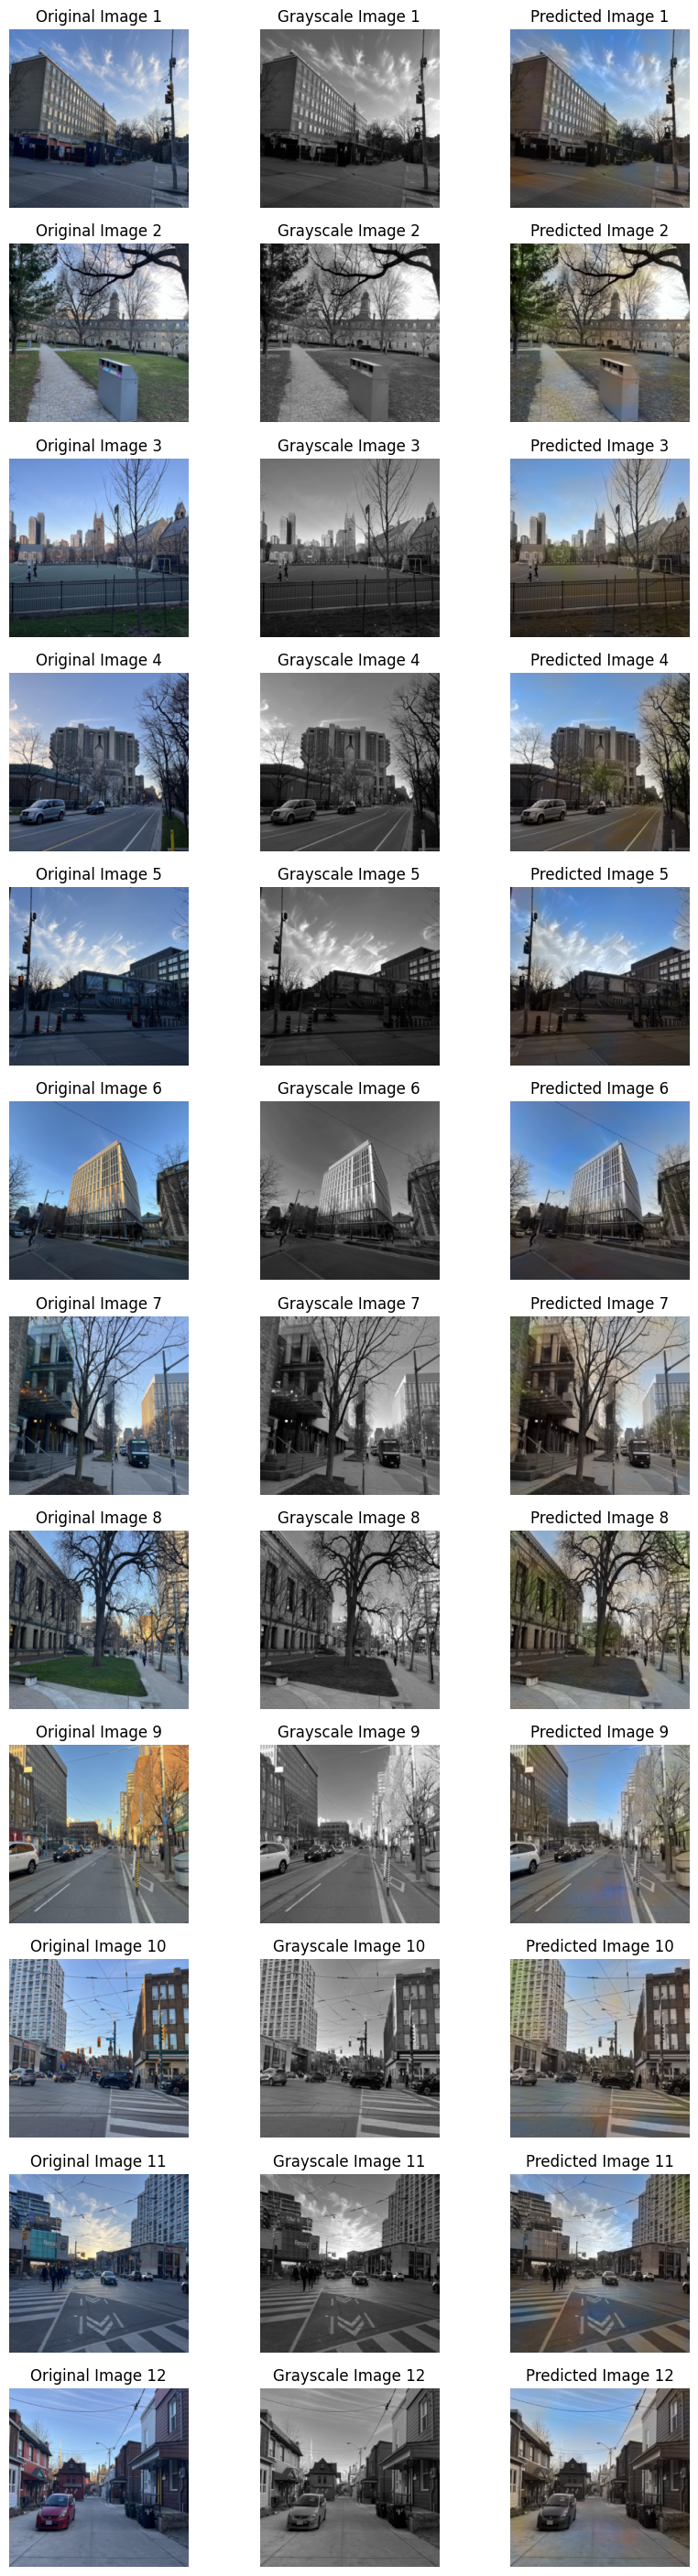

In [13]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from skimage.color import lab2rgb

model = ColorizationModel()

# Change path based on what dataset you are running
saved_model_path = '/content/drive/MyDrive/APS360_Project_Data/colorization_model_7.pth'

model.load_state_dict(torch.load(saved_model_path))

model.eval()

fig = plt.figure(figsize=(10, len(test_dataset)*3))

for i, image_number in enumerate(range(len(test_dataset))):

    # Original Image
    original_img = test_dataset[image_number].permute(1, 2, 0).numpy()
    ax = fig.add_subplot(len(test_dataset), 3, i*3 + 1)
    ax.imshow(original_img)
    ax.set_title(f'Original Image {image_number + 1}')
    ax.axis('off')

    # Grayscale Image
    gray_img = test_dataset[image_number][0].numpy()
    ax = fig.add_subplot(len(test_dataset), 3, i*3 + 2)
    ax.imshow(gray_img, cmap='gray')
    ax.set_title(f'Grayscale Image {image_number + 1}')
    ax.axis('off')

    # Predicted Image
    img = test_dataset[image_number].unsqueeze(0)
    imgs = img.permute(0, 2, 3, 1)
    imgs_np = imgs.numpy()
    img_lab = rgb2lab(imgs_np)
    L = img_lab[:, :, :, 0]

    L = torch.tensor(L, dtype=torch.float32).unsqueeze(0)
    AB = model(L)
    AB = torch.tensor(AB, dtype=torch.float32) * 128
    AB = AB.permute(0, 1, 2, 3)

    predicted_lab = torch.cat((L, AB), dim=1)
    predicted_rgb = lab2rgb(predicted_lab.squeeze().permute(1, 2, 0).detach().numpy())

    ax = fig.add_subplot(len(test_dataset), 3, i*3 + 3)
    ax.imshow(predicted_rgb)
    ax.set_title(f'Predicted Image {image_number + 1}')
    ax.axis('off')

plt.tight_layout(hspace=0.1)
plt.show()



CUDA is available!  Training on GPU ...
Epoch #0, Training Accuracy 0.5732333, Validation Accuracy 0.5193122, Loss 0.0061516
Epoch #1, Training Accuracy 0.5757846, Validation Accuracy 0.5143965, Loss 0.0048952
Epoch #2, Training Accuracy 0.5826674, Validation Accuracy 0.5197404, Loss 0.0044180
Epoch #3, Training Accuracy 0.5868934, Validation Accuracy 0.5186134, Loss 0.0046168
Epoch #4, Training Accuracy 0.5946942, Validation Accuracy 0.5174920, Loss 0.0041424
Epoch #5, Training Accuracy 0.5851055, Validation Accuracy 0.5014341, Loss 0.0048803
Epoch #6, Training Accuracy 0.5946376, Validation Accuracy 0.5095064, Loss 0.0047155
Epoch #7, Training Accuracy 0.6007202, Validation Accuracy 0.5089695, Loss 0.0039825
Epoch #8, Training Accuracy 0.6073895, Validation Accuracy 0.5081296, Loss 0.0044179
Epoch #9, Training Accuracy 0.6123066, Validation Accuracy 0.5098948, Loss 0.0036498
Epoch #10, Training Accuracy 0.6176635, Validation Accuracy 0.5156043, Loss 0.0034140
Epoch #11, Training Accu

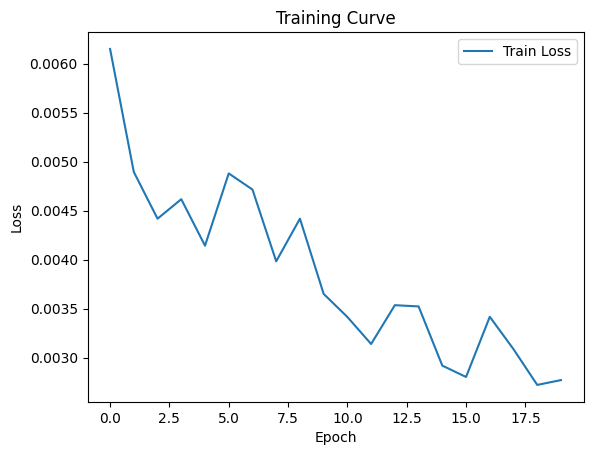

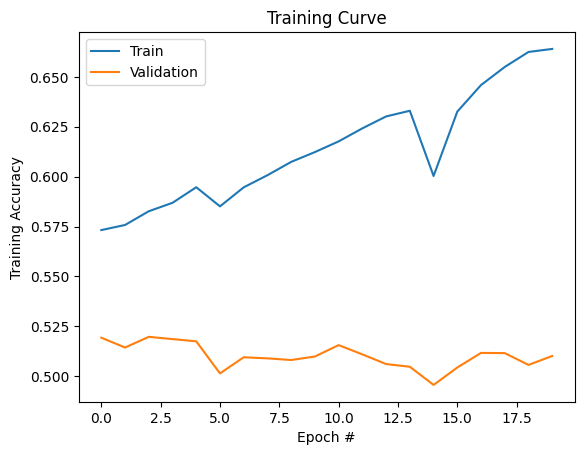

Final Training Accuracy: 0.6639827090176669
Final Validation Accuracy: 0.5101594026676399


In [ ]:
# Run 20 more epoches
model = ColorizationModel()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

pretrained_model_path = '/content/drive/MyDrive/APS360_Project_Data/colorization_model_7.pth'
model.load_state_dict(torch.load(pretrained_model_path))

# Train the model
train(model, train_loader, val_loader, num_epochs=20, learning_rate=0.0001)

# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/APS360_Project_Data/colorization_model_70.pth')